In [61]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import sys

from scipy.sparse.csr import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.manifold import TSNE


In [2]:
def saveKerasModel(modelName, model):
    model_json = model.to_json()
    with open(modelName, "w") as json_file:
        json_file.write(model_json)
def loadKerasModel(modelName):
    json_file = open(modelName, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model

In [9]:
!sudo aws s3 cp s3://RecipeVectors/unique_ingredients.pkl .
!sudo aws s3 cp s3://RecipeVectors/CleanedIngredients.pkl ./

download: s3://RecipeVectors/unique_ingredients.pkl to ./unique_ingredients.pkl


In [32]:
with open('unique_ingredients.pkl', 'rb') as f:
    unique_ingredients = pickle.load(f)

In [37]:
print np.random.choice(unique_ingredients,3)

['hog jowl' 'orangeflavored liqueur grand marnier' 'blueberry jelly']


In [28]:
df = pd.read_pickle('CleanedIngredients.pkl')

In [31]:
print df.columns.values
df.sample(3)

[u'categories' u'cookingTime' u'description' u'ingredients'
 u'instructionSteps' u'name' u'rating' u'ratingCount' u'url'
 'cookingTimeMinutes' 'cleanedIngredients']


,categories,cookingTime,description,ingredients,instructionSteps,name,rating,ratingCount,url,cookingTimeMinutes,cleanedIngredients
15717,"[Fruit Butters, Canning and Preserving, Sauces...",PT11H55M,NaN,"[8 large cooking apples - peeled, cored, and s...","[Place apples in a slow cooker. Cook on High, ...",Blueberry Apple Butter,4.86,6,http://allrecipes.com/recipe/229202/blueberry-...,715.0,"[cooking apples, blueberries, white sugar, cin..."
7836,"[Shrimp Recipes, Everyday Cooking, Main Dishes...",PT40M,NaN,"[1 tablespoon all-purpose flour, 2 tablespoons...","[In a dry frying pan, heat flour; stirring con...",Shrimp Creole I,4.40,9,http://allrecipes.com/recipe/12703/shrimp-creo...,40.0,"[flour, butter, tomato paste, onion, salt, red..."
13269,"[Lamb Recipes, Lamb Burgers, Burgers, Everyday...",PT25M,NaN,"[1 tablespoon minced garlic, 1/4 teaspoon grou...",[Preheat an outdoor grill for medium-high heat...,Lamb Sliders,5.00,1,http://allrecipes.com/recipe/257900/lamb-sliders/,25.0,"[garlic, cumin, coriander, allspice, salt, bla..."


# Classification Model 1, Categories Clustering as Label

Since a recipe can belong to multiple categories, and it is logical for a recipe to belong in multiple categories(i.e. a medium-rare steak can fit in following categories: beef, dinner, meat etc.) We first cluster the categories and assign each recipe with its respective index. 

In the subsequent classification, we will use the cluster index as the Y label, and then retrieve the centroid corresponding to the cluster index to output the general categories

In [324]:
from nltk.stem.snowball import *

stemmer = SnowballStemmer('english')
USELESS_CATEGORIES = set(map(stemmer.stem, ['recipes', 'and','main','dishes', 'cooking']))

def removeUselessCategories(arr):
    
    n_arr = []
    for category in arr:
        st_cat = stemmer.stem(category)
        for word in st_cat.split():
            if not word in USELESS_CATEGORIES:
                n_arr.append(word)
    return ' , '.join(n_arr)
df_cluster = df.copy()
df_cluster['allCategories'] = df_cluster['categories'].apply(removeUselessCategories)
df_cluster['allCategories'].sample(5)

13592    beef , appet , meat , poultry , appet , appeti...
6638     japanese , asian , salmon , fish , everyday , ...
3452     scandinavian , norwegian , norwegian , cooki ,...
451      squash , side , roasted , veget , vegetable , ...
3828     roasted , veget , brussels , sprouts , side , ...
Name: allCategories, dtype: object

In [44]:
def makePipeline():
    pipeline = Pipeline([
        ('vect', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('clf', KMeans(n_clusters=20, init='k-means++', max_iter=100, n_init=1))
    ])
    return pipeline

def trainModel(X):
    model = makePipeline()
    model.fit(X)
    return model

model = trainModel(df_cluster['allCategories'].values)
print("Top terms per cluster:")

vectorizer = model.named_steps['vect']
km = model.named_steps['clf']
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

true_k = 20
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print "Cluster %d:" % i
    for ind in order_centroids[i, :10]:
        print ' %s' % terms[ind]
    print

Top terms per cluster:
Cluster 0:
 cooki
 dessert
 fruit
 international
 drop
 bar
 christmas
 italian
 chocolate
 nut

Cluster 1:
 appet
 spread
 dips
 cheese
 snack
 appetizers
 salsa
 dip
 mexican
 bean

Cluster 2:
 pasta
 shap
 italian
 minute
 chees
 lasagna
 everyday
 macaroni
 vegetarian
 30

Cluster 3:
 soup
 soups
 chili
 stew
 stews
 canned
 chicken
 pea
 everyday
 beef

Cluster 4:
 chicken
 breast
 baked
 roasted
 everyday
 low
 asian
 style
 minute
 pasta

Cluster 5:
 seafood
 everyday
 vegetable
 low
 potato
 fish
 canned
 salmon
 squash
 mexican

Cluster 6:
 vegetarian
 indian
 vegan
 pea
 bean
 grain
 everyday
 calorie
 asian
 tofu

Cluster 7:
 cooki
 dessert
 chocolate
 christmas
 extract
 vanilla
 browni
 drop
 bar
 extracts

Cluster 8:
 breakfast
 brunch
 egg
 potato
 seafood
 pancak
 meat
 casserol
 bread
 everyday

Cluster 9:
 cak
 dessert
 cake
 mix
 chocolate
 holiday
 fruit
 pumpkin
 cupcak
 everyday

Cluster 10:
 dress
 stuffing
 thanksgiving
 sausage
 fall
 bre

In [47]:
# apply the cluster index to the model
df['category_cluster_index'] = model.predict(df['allCategories'].values)

In [49]:
df['category_cluster_index'].sample(5)

3960      2
14340     9
2202      2
3933      2
2256     11
Name: category_cluster_index, dtype: int32

## train model on the 20 cluster indexes
Here we are using the cluster indices as labels and concating the ingredient list together to create the features. We then train a RNN classification model. The first layer of our sequential model use the embedding of size 100, the second layer is a LSTM layer, we also added a dropout layer of 0.4. The final layer is a softmax layer to map it to one of our 20 indices. 

We run the model for 10 epochs and achieved an accuracy of 0.78. 

In [51]:
def concatIngredients(arr):
    return ','.join(arr).encode('ascii', 'ignore')

def processKerasModel(df_):
    embedding_length = 100
    top_words = 10000
    df = df_.copy()
    df['features'] = df['ingredients'].apply(concatIngredients)
    df['label'] = df['category_cluster_index']
    df = df[df['label'].astype(str) != 'nan']
    le = preprocessing.LabelEncoder()
    features = df['features'].values
    labels = df['label'].values
    
    le.fit(np.unique(labels))
    print list(le.classes_), 'num of labels:',len(np.unique(labels))
    labels = le.transform(labels) 
    print labels[:10]
#     X_train, Y_train, X_test, Y_test = ut.simpleSplit(features, labels)

    tokenizer = Tokenizer(nb_words=top_words)
    tokenizer.fit_on_texts(features)
    sequences = tokenizer.texts_to_sequences(features)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=embedding_length)

#     labels = np_utils.to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)

    # split the data into a training set and a validation set
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    nb_validation_samples = int(0.2 * data.shape[0])

    X_train = data[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    X_test = data[-nb_validation_samples:]
    y_test = labels[-nb_validation_samples:]
    
    embedding_vecor_length = 100
    model = Sequential()
    model.add(Embedding(top_words, embedding_vecor_length, input_length=embedding_length))
#     model.add(Dropout(0.5))
    model.add(LSTM(100)) #, return_sequences=True))
    model.add(Dropout(0.4))
#     model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(len(np.unique(labels)), activation='softmax'))
    
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
    print(model.summary())
    
    model.fit(X_train, y_train, epochs=10, batch_size=100)
    # Final evaluation of the model
    return model, X_test, y_test

rnn_cluster_model, X_test, y_test = processKerasModel(df_cluster)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] num of labels: 20
[ 1  1  5  0  4  3 16  6  4 16]


/Users/chuqinghe/anaconda/envs/py27/lib/python2.7/site-packages/keras/preprocessing/text.py:139: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 5486 unique tokens.
('Shape of data tensor:', (89061, 100))
('Shape of label tensor:', (89061,))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
Total params: 1,082,420
Trainable params: 1,082,420
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
71249/71249 [==============================] - 474s - loss: 2.1189 - acc: 0.3357   
Epoch 2/10
71249/71249 [==============================] - 419

The model accuracy on the train set is 0.78, the accuracy on the test set is 0.75. In total the model took about 2 hours to train

In [145]:
# save the model for future use
saveKerasModel('model_top_20_clustering_index.json',rnn_cluster_model)

In [325]:
# Load model if needed
# t_model = loadKerasModel('model_top_20_clustering_index.json')
# t_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Classification  Model 2: Top 30 Categories by Index
In this model, we have first extract the top 30 categories by doing counting the occurency of each category. Then we set the label of each recipe to one of the top 30 categories.  

In [25]:
from collections import Counter
unique_cat = Counter()
USELESS_CATEGORIES = ['recipes']
for idx, row in df.iterrows():
    for cat in row['categories']:
        cat = cat.lower()
        if not cat in USELESS_CATEGORIES:
            unique_cat[cat]+=1

In [26]:
TOP_K_CAT = 30
k_cat = [cat[0] for cat in unique_cat.most_common(TOP_K_CAT)]
k_cat

[u'everyday cooking',
 u'main dishes',
 u'desserts',
 u'appetizers and snacks',
 u'pasta by shape',
 u'chicken breasts',
 u'asian recipes',
 u'side dishes',
 u'pasta main dishes',
 u'soups, stews and chili',
 u'fruit desserts',
 u'italian recipes',
 u'salad recipes',
 u'bread recipes',
 u'breakfast and brunch',
 u'mexican recipes',
 u'cake recipes',
 u'faceless recipes',
 u'drinks',
 u'cookies',
 u'soup',
 u'trusted brands',
 u'baked and roasted chicken',
 u'dips and spreads',
 u'vegan recipes',
 u'fish recipes',
 u'casseroles',
 u'canned beans and peas',
 u'vanilla extract',
 u'cheese appetizers']

## Map each recipe to a category
since each recipe contains multiple categories, we loop through the categories list for each recipe, and map the recipe to ONE category in the TOP_K_CAT list. If a recipe doesn't belong in any category, we map it to 'Other'

In [27]:
def mapToSingleCategory(arr):
    for item in arr:
        if item.lower() in k_cat:
            return item.lower()
    return 'other'
df_single_cat = df.copy()
df_single_cat['cat_label'] = df_single_cat['categories'].apply(mapToSingleCategory)
df_single_cat['cat_label'].value_counts()

everyday cooking             12170
side dishes                   5847
fruit desserts                4884
salad recipes                 4733
asian recipes                 4434
chicken breasts               4350
breakfast and brunch          3999
italian recipes               3761
appetizers and snacks         3679
desserts                      3633
trusted brands                3416
soup                          3366
bread recipes                 3270
cookies                       3180
dips and spreads              3033
pasta by shape                3030
drinks                        2903
cake recipes                  2490
main dishes                   2264
mexican recipes               2220
soups, stews and chili        2099
fish recipes                  1812
cheese appetizers             1318
casseroles                    1201
baked and roasted chicken      675
pasta main dishes              497
vegan recipes                  440
other                          348
vanilla extract     

## Create Embedding using the unique_ingredients
We have already created a list of unique_ingredients, we have already create the corresponding MxN embedding matrix, where M = number of unique recipes, and N = the embedding size. In our case, we have M = 18996 unique ingredients.

This takes a long time so we processed and stored the word embedding matrix in sparse_recipe_ingredient_matrix.npz. We just need to map those to the categories for training.

In [5]:
with open('reduced_cooccurrence_matrix.pkl', 'rb') as f:
    reduced_cooccurrence_matrix = pickle.load(f)

In [ ]:
print 'Unique Ingredients: ',len(unique_ingredients)
print 'Embedding matrix shape: ',reduced_cooccurrence_matrix.shape
def createIndexMappingAndWordVec():
    word_to_idx_mapping = {}
    word_vec = {}
    for idx, word in enumerate(unique_ingredients):
        word_to_idx_mapping[word] = idx
        word_vec[word] = reduced_cooccurrence_matrix[idx]
    return word_to_idx_mapping, word_vec
word_to_idx_mapping, word_vec = createIndexMappingAndWordVec()

# test the embedding is working:
print 'Index for ingredient(lessfat cream cheese):',  word_to_idx_mapping['lessfat cream cheese']
print 'embedding vector for ingredient(lessfat cream cheese): ', word_vec['lessfat cream cheese']

After creating the word_to_idx_mapping and word_vec, we must iterate over each recipe, and for each ingredient list, map the ingredient to its corresponding index in the word_to_idx_mapping

In [48]:
def parseDataset(ingredientList):
    ingredientsIndexList = []
    for ingredient in ingredientList:
        try:
            ingredientsIndexList.append(word_to_idx_mapping[ingredient])
        except:
            ingredientsIndexList.append(0)
    return ingredientsIndexList
df_single_cat['cleanedIngredientsIndexedList'] = df_single_cat['cleanedIngredients'].apply(parseDataset)

In [49]:
# check that we have the correct indexed list
print df_single_cat.iloc[3739][['cleanedIngredients','cleanedIngredientsIndexedList']]
print word_to_idx_mapping['nonfat plain yogurt']

cleanedIngredients               [nonfat plain yogurt, peanut butter, banana, s...
cleanedIngredientsIndexedList                     [11287, 12081, 873, 16247, 8249]
Name: 4972, dtype: object
11287


In [50]:
df_single_cat['features'] = df_single_cat['cleanedIngredientsIndexedList']

## encode the labels
Here we use sklearn's preprocessing to encode the 30 labels into indices; the final softmax layer in our classification model will be a vector of length 30, corresponding to the probability of each label for a given input. 

In [51]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_single_cat['cat_label'])
print le.classes_

[u'appetizers and snacks' u'asian recipes' u'baked and roasted chicken'
 u'bread recipes' u'breakfast and brunch' u'cake recipes' u'casseroles'
 u'cheese appetizers' u'chicken breasts' u'cookies' u'desserts'
 u'dips and spreads' u'drinks' u'everyday cooking' u'fish recipes'
 u'fruit desserts' u'italian recipes' u'main dishes' u'mexican recipes'
 'other' u'pasta by shape' u'pasta main dishes' u'salad recipes'
 u'side dishes' u'soup' u'soups, stews and chili' u'trusted brands'
 u'vanilla extract' u'vegan recipes']


In [54]:
df_single_cat['label'] = le.transform(df_single_cat['cat_label'])
df_final = df_single_cat[['features','label']]
df_final.sample(5)

,features,label
506,"[13113, 14761, 6387, 2502, 10753]",23
7910,"[12894, 2834, 9741, 14742, 2502, 16106]",0
14197,"[1141, 14745, 18123, 16820, 9498, 15865]",13
15709,"[11101, 17879, 2205, 11101, 5778, 6099, 6091, ...",23
2971,"[3332, 14761, 11532, 2956, 3055, 13113, 18123]",13


In [55]:
# test the encoding works
le.inverse_transform([6,12,0])

array([u'casseroles', u'drinks', u'appetizers and snacks'], dtype=object)

## Finalized Dataset
The final dataset is split into Train/Test sets,  we can now pipe this through a CNN model with softmax layer. 

In [62]:
# define the variables
VOCAB_SIZE = len(word_to_idx_mapping)
EMBEDDING_SIZE = 50
MAX_LEN = 50

In [63]:
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence

features = np.array([np.array(row) for row in df_final['features'].values])
labels = df_final['label'].values

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

print 'X_train shape:', X_train.shape
print 'y_train shape:', y_train.shape
print 'X_test shape:', X_test.shape
print 'y_test shape:', y_test.shape
# print 'sample X:', np.random.choice(X_train, 3)

X_train shape: (71248, 50)
y_train shape: (71248,)
X_test shape: (17813, 50)
y_test shape: (17813,)


In [84]:
# global max pooling : https://www.quora.com/What-is-global-average-pooling
# CNN for text classification: https://arxiv.org/pdf/1408.5882.pdf

from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.utils import to_categorical


def trainKerasModel_conv(X,Y):
    print('Shape of data tensor:', X.shape)
    print('Shape of label tensor:', Y.shape)

    print('Training model.')
    # train a 1D convnet with global maxpooling
    sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
    embedding_layer = Embedding(VOCAB_SIZE,
                        EMBEDDING_SIZE,
                        weights=[reduced_cooccurrence_matrix],
                        input_length=MAX_LEN,
                        trainable=False)
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(len(le.classes_), activation='softmax')(x)
    model = Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
    print model.summary()
    model.fit(X, Y, epochs=10, batch_size=MAX_LEN)
    # Final evaluation of the model
    return model

conv_model = trainKerasModel_conv(X_train, y_train)

('Shape of data tensor:', (71248, 50))
('Shape of label tensor:', (71248,))
Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 50)                0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 50, 50)            949800    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 46, 128)           32128     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               147584    
__________________________________________________

The performance resulted in a relatively terrible accuracy of 0.15. This may be due to the fact we have already created the embedding weight matrix and disabled changing the matrix during the training. Overall I don't believe we will use a Convolutional Model for our classification problem 

# Word to Vec Model

Word to vec using gensim: https://radimrehurek.com/gensim/models/word2vec.html  
Here we are creating the word vectors from the list of clean ingredients. We use the Gensim model to create the similarity matrix(cosine similarity)



In [7]:
from gensim.models.word2vec import Word2Vec

print('Training a Word2vec model...')
w2v_model = Word2Vec(df['cleanedIngredients'].values, size=100, window=5, min_count=5, workers=4)

Training a Word2vec model...


In [8]:
w2v_model.wv.most_similar(positive=['onion'])

[('onions', 0.8888660669326782),
 ('yellow onion', 0.8329431414604187),
 ('sweet onion', 0.7874157428741455),
 ('white onion', 0.743157684803009),
 ('onion rings', 0.7064717411994934),
 ('yellow onions', 0.6754041910171509),
 ('sweet onions', 0.6720933318138123),
 ('onions rings', 0.6356331706047058),
 ('red onion', 0.6126598119735718),
 ('sweet onion vidali', 0.6097730398178101)]

In [9]:
w2v_model.wv.most_similar(positive=['chicken'], negative=['eggs'])

[('skinless boneless chicken breast', 0.5533419847488403),
 ('scallions', 0.5313525199890137),
 ('boneless skinless chicken breast', 0.5157349705696106),
 ('chicken breast', 0.47965073585510254),
 ('red bell peppers', 0.46481847763061523),
 ('boneless skinless chicken breasts', 0.4563044309616089),
 ('radishes', 0.4494268596172333),
 ('green onions', 0.44582998752593994),
 ('boneless chicken breast', 0.4406493902206421),
 ('skinless boneless chicken breasts', 0.44022032618522644)]

In [62]:
X = w2v_model[w2v_model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

vocab = list(w2v_model.wv.vocab)
df_tsne = pd.concat([pd.DataFrame(X_tsne),
                pd.Series(vocab)],
               axis=1)
df_tsne.columns = ['x', 'y', 'ingredient']
df_tsne.sample(5)

,x,y,ingredient
1816,9.048788,2.880225,brewed green tea
5178,-2.648753,2.289774,orange peel
3368,6.516062,-0.583308,assorted wild mushrooms
537,-0.254504,-1.017464,sweet onion vidali
3851,-4.612746,6.581706,paprika garnish


In [22]:
def showTSNEGraphForWord(pos_words = [], neg_words = []):
    vec = w2v_model.wv.most_similar(positive=pos_words, negative = neg_words)
    ingredients = [w[0] for w in vec]
    vec_df = df_tsne[df_tsne['ingredient'].isin(ingredients)]
    print vec_df
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for i, txt in enumerate(vec_df['ingredient']):
        ax.annotate(txt, (vec_df['x'].iloc[i], vec_df['y'].iloc[i]))

    ax.scatter(vec_df['x'], vec_df['y'])   

             x         y          ingredient
300   6.769933  9.731587         white onion
537  -3.650885 -1.205307  sweet onion vidali
1669 -2.204439 -0.789229         onion rings
1691 -2.900957 -1.764410       yellow onions
3084 -4.271641  1.976724        onions rings
3286 -2.528971  4.322207        sweet onions
3559  6.811886  9.726264           red onion
4707  6.781185  9.734677         sweet onion
4895  6.772881  9.738325        yellow onion
5453  6.770591  9.753330              onions


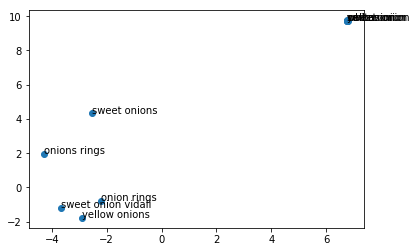

In [23]:
showTSNEGraphForWord(pos_words=['onion']) 

             x         y                             ingredient
602  -5.591169 -1.630994       boneless skinless chicken thighs
784  -5.278197 -2.406092      boneless skinless chicken breasts
975   0.443119 -2.024389                           chicken meat
1193 -2.137527 -0.534196                         longgrain rice
1746 -1.225973 -5.776664       skinless boneless chicken breast
2237 -1.169211 -5.726242      skinless boneless chicken breasts
3012  0.158432 -2.334817                boneless chicken breast
3227  0.094982 -2.434705                         chicken breast
3650 -6.405356 -0.498479                 edamame green soybeans
5034 -5.490782 -2.239375  skinless boneless chicken breast meat


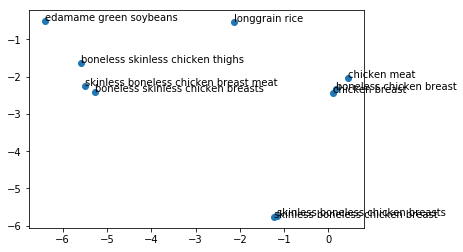

In [25]:
showTSNEGraphForWord(pos_words=['chicken', 'rice'], neg_words=['onions']) 

             x         y              ingredient
50   -1.045474  4.949342         pork neck bones
143  -2.572000  4.501688             beef oxtail
158  -2.493392  4.725720  boneless lamb shoulder
873   7.733906  3.319230              pork liver
1953 -1.179269  4.903063          polish sausage
1957  8.100807  1.430370          fully kielbasa
2798 -2.763307  4.735649           baking potato
3813 -1.722844 -2.386843              beef chuck
4446  7.877756  1.494449     chicken legs patted
4905 -2.593800  4.001792             chuck roast


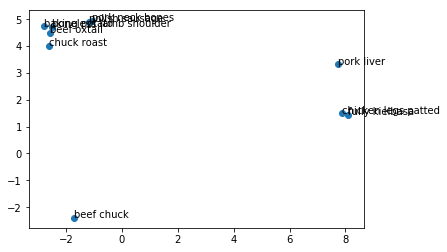

In [27]:
showTSNEGraphForWord(pos_words=['beef', 'beets']) 

# Extract the verbs from the instruction
Here we are using the NLTK POS tagger to extract the verbs from the instruction list. 

In [ ]:
import nltk
# download the avg perceptron tagger from nltk
# nltk.download('averaged_perceptron_tagger')

In [59]:
def extractVerbs(row):
    instructions = row['instructionSteps']
    tokens = []
    for inst in instructions:
        tokens += inst.split()
    lstTags = nltk.pos_tag(tokens)
    verbs = []
    for item in lstTags:
        if item[1] == 'VB':
            verbs.append(item[0])
    return set(verbs)
df_verbs = df.copy()
df_verbs['verbs'] = df_verbs.apply(extractVerbs, axis=1)

In [60]:
print df_verbs['verbs'].sample(5)

10732                              {coat.}
11982                {pepper;, coat, cook}
1174                                    {}
13406    {serve., add, blend., let, spoon}
1572     {refrigerate, make, refrigerate.}
Name: verbs, dtype: object


Append the verbs to the ingredients, hopefully we see a pattern developing from the actions associated with ingredients

In [68]:
def combineIngredientActions(row):
    return row['cleanedIngredients'] + list(row['verbs'])
df_verbs['combined_action_ingredients'] = df_verbs.apply(combineIngredientActions, axis=1)
print('Training a Word2vec model for ingredients + actions...')
action_ingredients_w2v_model = Word2Vec(df_verbs['combined_action_ingredients'].values, size=100, window=5, \
                                        min_count=5, workers=4)

Training a Word2vec model for ingredients + actions...


In [69]:
action_ingredients_w2v_model.wv.most_similar(positive=['chopped'])

[('unseasoned bread stuffing mix', 0.7595873475074768),
 ('white kidney beans', 0.7457982897758484),
 ('sausage conecuh(c)', 0.7244827151298523),
 ('skinless bonein chicken breast', 0.7087138891220093),
 ('chicken broth goodness(r)', 0.7061499357223511),
 ('rotinicorkscrew pasta', 0.7045194506645203),
 ('rotisserie chicken boned', 0.703870415687561),
 ('chicken broth vegetable', 0.7013994455337524),
 (u'center.', 0.697180986404419),
 (u'sausage.', 0.693701982498169)]

In [70]:
X = action_ingredients_w2v_model[action_ingredients_w2v_model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

vocab = list(action_ingredients_w2v_model.wv.vocab)
df_tsne = pd.concat([pd.DataFrame(X_tsne),
                pd.Series(vocab)],
               axis=1)
df_tsne.columns = ['x', 'y', 'ingredient']
df_tsne.sample(5)

,x,y,ingredient
2811,0.948420,8.088354,help
4797,1.460814,0.989657,pork sausage links
4854,-1.732902,5.457736,white anchovies
340,4.782015,-0.531788,acorn squash
3132,-7.110087,-1.604602,chocolate sandwich cookies creme filling


In [74]:
def showTSNEGraphForIngredientActions(pos_words = [], neg_words = []):
    vec = action_ingredients_w2v_model.wv.most_similar(positive=pos_words, negative = neg_words)
    ingredients = [w[0] for w in vec]
    vec_df = df_tsne[df_tsne['ingredient'].isin(ingredients)]
    print vec_df
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for i, txt in enumerate(vec_df['ingredient']):
        ax.annotate(txt, (vec_df['x'].iloc[i], vec_df['y'].iloc[i]))

    ax.scatter(vec_df['x'], vec_df['y'])   

             x         y                ingredient
1357 -3.837527  3.314324               tomatoes up
1834 -4.598423  1.801319             crab stuffing
1902 -4.118521 -4.982139      blue cheese dressing
2173  1.519488  2.525308    boneless turkey breast
3455 -3.433303  2.517599              live oysters
4940 -3.975646  1.385500               cream sauce
5862 -5.179808  3.852344             chicken boned
5870 -3.232908 -0.391952       green onion topping
6196 -6.371567  2.890874  rotisserie chicken boned
6919  1.531154  4.452622                    onion.


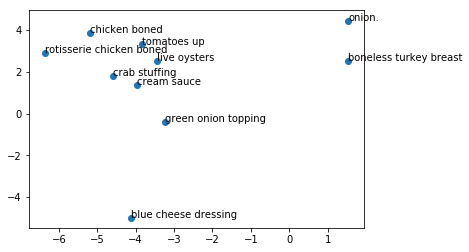

In [76]:
showTSNEGraphForIngredientActions(pos_words=['chopped', 'chicken'], neg_words=['onions']) 

In [ ]:
showTSNEGraphForIngredientActions(pos_words=['ba', 'onion'], neg_words=['beef']) 

# Generative Model 3
Let's do something fun and generate the recipes from scratch :D

Inspired By:   
http://karpathy.github.io/2015/05/21/rnn-effectiveness/   
https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

In [8]:
df = pd.read_pickle('CleanedIngredients.pkl')
df.columns.values

array([u'categories', u'cookingTime', u'description', u'ingredients',
       u'instructionSteps', u'name', u'rating', u'ratingCount', u'url',
       'cookingTimeMinutes', 'cleanedIngredients'], dtype=object)

In [125]:

import re
def processCategories(arr):
    arr = [re.sub(r'[\xa0\x99]', ' ', k.encode('ascii', 'ignore')) for k in arr]
    return '<category> ' + ','.join(arr) + ' </category>'
def processIngredients(arr):
    arr = [re.sub(r'[\xa0\x99]', ' ', k.encode('ascii', 'ignore')) for k in arr]
    return '<ingredients> ' + ','.join(arr) + ' </ingredients>'
def processName(text):
    return '<name> '+ text+' </name>'
def processDesc(text):
    if text == text:
        text = re.sub(r'[\xa0\x99]', ' ', text.encode('ascii', 'ignore'))
        return '<desc> '+ str(text) +' </desc>'
    return '<no_desc>'
def processInstructions(arr):
    if not arr == arr:
        return '<no_inst>'
    retStr = '<inst> '
    for i, inst in enumerate(arr):
        inst = re.sub(r'[\xa0\x99]', ' ', inst.encode('ascii', 'ignore'))
        retStr += (str(i) +' : '+inst + ' ')
    retStr += ' </inst>'
    return retStr
def getRating(text):
    return '<rating> ' + str(text) + ' </rating>' 
def addRowsTogether(row):
    return ' '.join(row[['ingredients', 'name','instructionSteps']])


df_recipe_generator = df.copy()
df_recipe_generator['categories'] = df_recipe_generator['categories'].apply(processCategories)
df_recipe_generator['name'] = df_recipe_generator['name'].apply(processName)
df_recipe_generator['ingredients'] = df_recipe_generator['ingredients'].apply(processIngredients)
df_recipe_generator['description'] = df_recipe_generator['description'].apply(processDesc)
df_recipe_generator['rating'] = df_recipe_generator['rating'].apply(getRating)
df_recipe_generator['instructionSteps'] = df_recipe_generator['instructionSteps'].apply(processInstructions)

df_recipe_generator['total_recipe'] = df_recipe_generator.apply(addRowsTogether, axis=1)


In [128]:
df_recipe_generator['total_recipe'].sample(5)

7211     <ingredients> 3 tablespoons olive oil,1 pound ...
10220    <ingredients> 1 teaspoon vegetable oil,1 shall...
4104     <ingredients> 4 slices whole-grain bread, ligh...
23550    <ingredients> 1/3 cup soy sauce,2/3 cup white ...
12382    <ingredients> 2 tablespoons butter,5 slices ba...
Name: total_recipe, dtype: object

In [129]:
data = df_recipe_generator['total_recipe'].values
chars = list(set(data))
VOCAB_SIZE = len(chars)
SEQ_LENGTH = 200

In [130]:
chars = sorted(list(set(data)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


('total chars:', 45211)


In [131]:

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(data) - maxlen, step):
    sentences.append(data[i: i + maxlen])
    next_chars.append(data[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


('nb sequences:', 29674)
Vectorization...


In [132]:
print y[:10]

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


In [ ]:
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop

print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y,
              batch_size=128,
              epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

Build model...
()
--------------------------------------------------
('Iteration', 1)
Epoch 1/1
 8448/29674 [=======>......................] - ETA: 1750s - loss: 10.9706